# Insurtech: Categorical Risk

## Background

The insurance business revolves around quantifying risk: the insurer invests insurance premiums in financial markets, and makes payouts in the form of insurance claims. Both investments and claims payouts require models in order to quantify and predict risk, or the level of potential financial loss. 

This dataset contains historical claims payouts for a number of different medical insurance buyers, along with their characteristics ("age", "smoker", and so forth). Can you build a deep neural network that uses people's characteristics to quantify the potential level of dollar claims, and can you model be made robust to overfitting? 

## Instructions

### Preparing the Data
1) Read in the data.

2) Use `pd.qcut` to split the dependent variable, `charges`, into 5 categorical buckets. Save this result to a `charges_quantile` column.

3) Use `LabelEncoder` and `to_categorical` to set this column as your `y` variable. 

4) Set the remaining data as your `X` data.

5) Split the data into training and test windows using `train_test_split`.

### Fitting the Model

1) Fit and evaluate the model, including at least one dropout layer, and one layer with regularization. Include a validation set as part of fitting the model.

2) Plot performance on the training and validation set across epochs. 

3) Finally, re-fit the new model, adjusting the amount of epochs for training so as to avoid overfitting as much as possible.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation

# This code is neccessary to produce the same results every time
import tensorflow as tf
tf.keras.utils.set_random_seed(1)

In [3]:
# Upload the data
from google.colab import files
uploaded = files.upload()

Saving insurance_claims.csv to insurance_claims.csv


In [4]:
# Read in the data
df = pd.read_csv('insurance_claims.csv')

In [5]:
df.head()

,age,bmi,children,smoker,charges
0,19,27.900,0,1,16884.92400
1,18,33.770,1,0,1725.55230
2,28,33.000,3,0,4449.46200
3,33,22.705,0,0,21984.47061
4,32,28.880,0,0,3866.85520


In [6]:
# Use qcut to group claims data ("charges") into 5 buckets
df['charges_quantile'] = (pd.qcut(df['charges'], q=5, labels=False))+1
# Verify buckets are approximately balanced 
# (Slight imbalance from ties is OK)
df['charges_quantile'].value_counts()

1    268
5    268
3    268
4    267
2    267
Name: charges_quantile, dtype: int64

In [7]:
# Save bucket ("quantile") value as the new  `y` variable
y_quantile = df['charges_quantile']

In [8]:
# Save the unique count of categories for later use
number_of_classes = len(y_quantile.unique())

In [9]:
# Encode quantiles into labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_quantile)
encoded_y = encoder.transform(y_quantile)
encoded_y

array([3, 0, 1, ..., 0, 0, 4])

In [10]:
# Encode labels into categories
from keras.utils.np_utils import to_categorical
y_categorical = to_categorical(encoded_y, num_classes=number_of_classes)
y_categorical

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
# Specify X (predictor) variables
X = df[['age','bmi','children', 'smoker']]
X.head(3)

,age,bmi,children,smoker
0,19,27.90,0,1
1,18,33.77,1,0
2,28,33.00,3,0


In [12]:
# Split into training and testing windows
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=1)

In [13]:
# Preview the `y_train` values
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [14]:
# Save the count of unique predictor variables for use in model
number_of_predictors = len(X.columns)
len(X.columns)

4

### Build the Model



In [15]:
# Import the `Dropout` layer
from keras.layers import Dropout
# Import regularization functions
from keras.regularizers import l1, l2

In [16]:
# Build the Model
model = Sequential()
# Add a dense layer
model.add(Dense(10, input_dim=number_of_predictors, activation='relu'))
# Now add a dropout layer
model.add(Dropout(.2,input_shape=(10,)))
# Add another dense layer
model.add(Dense(5, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

In [17]:
# Add the final output layer
# (Set the # of possible outputs equal to the number classes)
model.add(Dense(number_of_classes, activation='softmax'))

In [18]:
# Compile the model
model.compile(loss="categorical_crossentropy", 
              optimizer= "adam", 
              metrics=['categorical_accuracy'])

In [19]:
# Summarise the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Add in validation loss to select the number of epochs
# Fit the model
number_of_epochs = 50
model.fit(X_train,y_train, 
                    epochs=number_of_epochs,
                    batch_size=10,
                      validation_split=0.2,
                    shuffle=True)

Epoch 1/50
81/81 [==============================] - 1s 5ms/step - loss: 3.8739 - categorical_accuracy: 0.1509 - val_loss: 1.7619 - val_categorical_accuracy: 0.1642
Epoch 2/50
81/81 [==============================] - 0s 2ms/step - loss: 2.1741 - categorical_accuracy: 0.1945 - val_loss: 1.6525 - val_categorical_accuracy: 0.1990
Epoch 3/50
81/81 [==============================] - 0s 3ms/step - loss: 1.8667 - categorical_accuracy: 0.2107 - val_loss: 1.6409 - val_categorical_accuracy: 0.2040
Epoch 4/50
81/81 [==============================] - 0s 2ms/step - loss: 1.7861 - categorical_accuracy: 0.2132 - val_loss: 1.6358 - val_categorical_accuracy: 0.2040
Epoch 5/50
81/81 [==============================] - 0s 2ms/step - loss: 1.7276 - categorical_accuracy: 0.2095 - val_loss: 1.6324 - val_categorical_accuracy: 0.2040
Epoch 6/50
81/81 [==============================] - 0s 2ms/step - loss: 1.6820 - categorical_accuracy: 0.2157 - val_loss: 1.6302 - val_categorical_accuracy: 0.2040
Epoch 7/50
81/81

In [21]:
# Save model history across epochs
model_history = model.history.history
model_history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [22]:
# View `categorical_accuracy` for the training dataset
model_history['categorical_accuracy']

[0.15087281167507172,
 0.1945137083530426,
 0.21072319149971008,
 0.21321696043014526,
 0.2094763070344925,
 0.21571072936058044,
 0.22693267464637756,
 0.21820448338985443,
 0.21197007596492767,
 0.21571072936058044,
 0.21945136785507202,
 0.21072319149971008,
 0.20573565363883972,
 0.21695759892463684,
 0.21571072936058044,
 0.19077306985855103,
 0.21321696043014526,
 0.21072319149971008,
 0.2206982523202896,
 0.2094763070344925,
 0.2082294225692749,
 0.2793017327785492,
 0.27057355642318726,
 0.2668329179286957,
 0.2655860483646393,
 0.3441396653652191,
 0.3354114592075348,
 0.3366583585739136,
 0.3441396653652191,
 0.3453865349292755,
 0.35660848021507263,
 0.3341645896434784,
 0.361596018075943,
 0.33915212750434875,
 0.36783042550086975,
 0.34039899706840515,
 0.36783042550086975,
 0.38528677821159363,
 0.35286784172058105,
 0.38154613971710205,
 0.3491271734237671,
 0.35660848021507263,
 0.35785534977912903,
 0.3740648329257965,
 0.3740648329257965,
 0.38154613971710205,
 0.3690

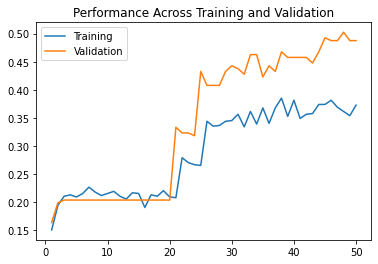

In [23]:
# Save accuracy for training and validation set across epochs
training_results = pd.DataFrame(index=range(1,number_of_epochs+1))
training_results['Training'] = model_history['categorical_accuracy']
training_results['Validation'] = model_history['val_categorical_accuracy']
training_results.plot(title = 'Performance Across Training and Validation')

In [24]:
# Add in validation loss to select the number of epochs
# Fit the model
number_of_epochs = 10
model.fit(X_train,y_train, 
                    epochs=number_of_epochs,
                    batch_size=10,
                      validation_split=0.2,
                    shuffle=True)

Epoch 1/10
81/81 [==============================] - 0s 3ms/step - loss: 1.4348 - categorical_accuracy: 0.3691 - val_loss: 1.3175 - val_categorical_accuracy: 0.4826
Epoch 2/10
81/81 [==============================] - 0s 3ms/step - loss: 1.4218 - categorical_accuracy: 0.3678 - val_loss: 1.3186 - val_categorical_accuracy: 0.4975
Epoch 3/10
81/81 [==============================] - 0s 2ms/step - loss: 1.4304 - categorical_accuracy: 0.3915 - val_loss: 1.3221 - val_categorical_accuracy: 0.4876
Epoch 4/10
81/81 [==============================] - 0s 2ms/step - loss: 1.4089 - categorical_accuracy: 0.3878 - val_loss: 1.3188 - val_categorical_accuracy: 0.4776
Epoch 5/10
81/81 [==============================] - 0s 2ms/step - loss: 1.4235 - categorical_accuracy: 0.3890 - val_loss: 1.3294 - val_categorical_accuracy: 0.4776
Epoch 6/10
81/81 [==============================] - 0s 2ms/step - loss: 1.4127 - categorical_accuracy: 0.3778 - val_loss: 1.3122 - val_categorical_accuracy: 0.5075
Epoch 7/10
81/81